Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)         2

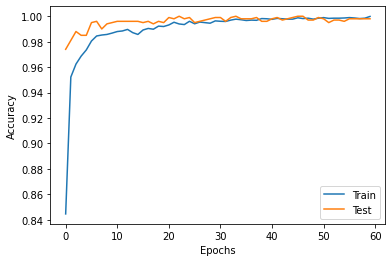

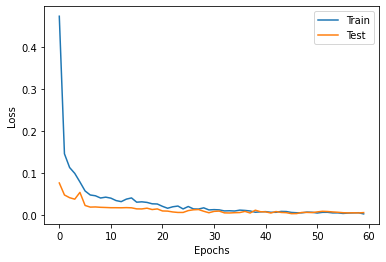

<AxesSubplot:>

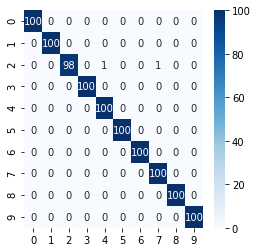

In [1]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/ARDIS/ARDIS_DATASET_III/'
nb_train_samples = 6600
nb_validation_samples = 1000
num_classes = 10

# learning params
epochs1 = 10
epochs2 = 50
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned50

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
                    fill_mode='constant',
                    cval = 0,
                    validation_split=0.132
                )
valid_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.132)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=17)
validation_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=17)

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [2]:
# calculate different metrics for HCR-Net on the test dataset
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.998019801980198
recall_score   :  0.998
f1_score       :  0.997994874114277
accuracy_score :  0.998

Best accuracy  :  1.0


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

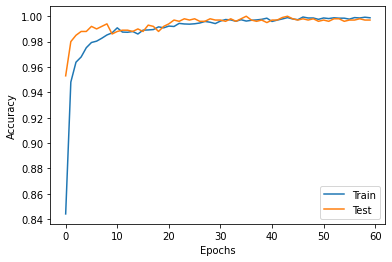

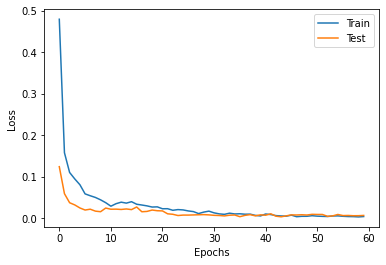

<AxesSubplot:>

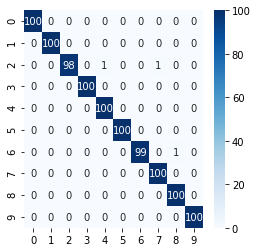

In [3]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/ARDIS/ARDIS_DATASET_III/'
nb_train_samples = 6600
nb_validation_samples = 1000
num_classes = 10

# learning params
epochs1 = 10
epochs2 = 50
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned50

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
                    fill_mode='constant',
                    cval = 0,
                    validation_split=0.132
                )
valid_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.132)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=16)
validation_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=16)

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [4]:
# calculate different metrics for HCR-Net on the test dataset
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9970297029702969
recall_score   :  0.9970000000000001
f1_score       :  0.996994849113652
accuracy_score :  0.997

Best accuracy  :  1.0


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

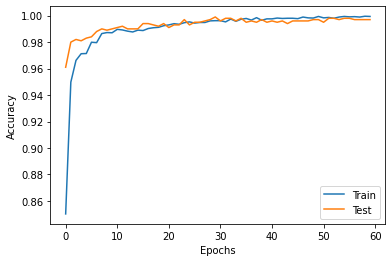

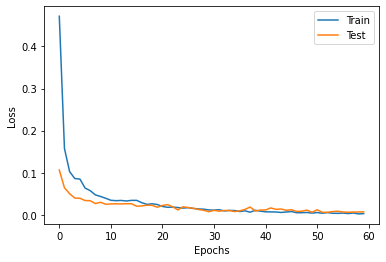

<AxesSubplot:>

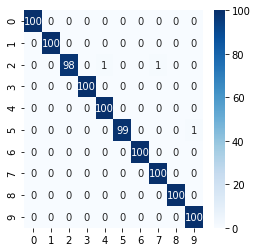

In [5]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/ARDIS/ARDIS_DATASET_III/'
nb_train_samples = 6600
nb_validation_samples = 1000
num_classes = 10

# learning params
epochs1 = 10
epochs2 = 50
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned50

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
                    fill_mode='constant',
                    cval = 0,
                    validation_split=0.132
                )
valid_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.132)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=15)
validation_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=15)

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [6]:
# calculate different metrics for HCR-Net on the test dataset
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9970297029702969
recall_score   :  0.9970000000000001
f1_score       :  0.996994849113652
accuracy_score :  0.997

Best accuracy  :  0.9990000128746033


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

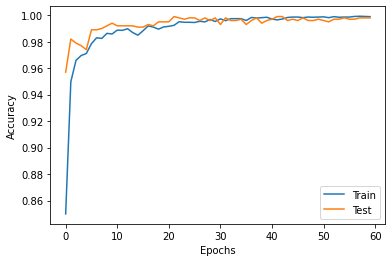

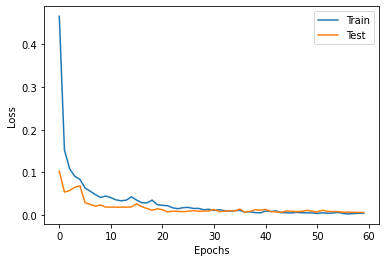

<AxesSubplot:>

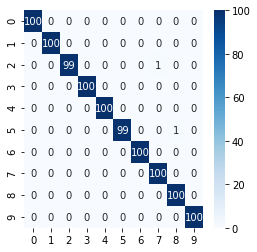

In [7]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/ARDIS/ARDIS_DATASET_III/'
nb_train_samples = 6600
nb_validation_samples = 1000
num_classes = 10

# learning params
epochs1 = 10
epochs2 = 50
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned50

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
                    fill_mode='constant',
                    cval = 0,
                    validation_split=0.132
                )
valid_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.132)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=14)
validation_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=14)

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [8]:
# calculate different metrics for HCR-Net on the test dataset
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.998019801980198
recall_score   :  0.998
f1_score       :  0.99799994999875
accuracy_score :  0.998

Best accuracy  :  0.9990000128746033


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

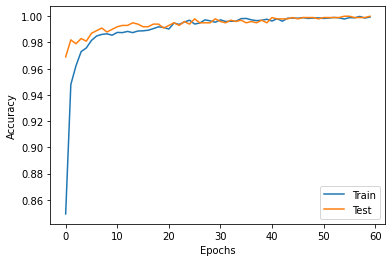

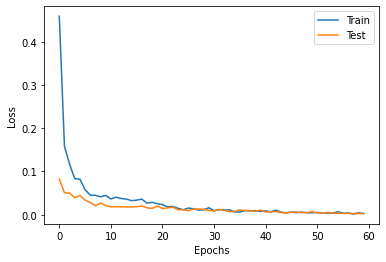

<AxesSubplot:>

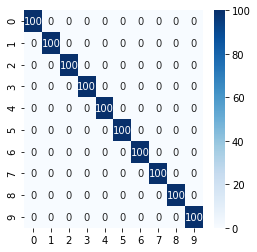

In [9]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/ARDIS/ARDIS_DATASET_III/'
nb_train_samples = 6600
nb_validation_samples = 1000
num_classes = 10

# learning params
epochs1 = 10
epochs2 = 50
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned50

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
                    fill_mode='constant',
                    cval = 0,
                    validation_split=0.132
                )
valid_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.132)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=13)
validation_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=13)

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [10]:
# calculate different metrics for HCR-Net on the test dataset
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  1.0
recall_score   :  1.0
f1_score       :  1.0
accuracy_score :  1.0

Best accuracy  :  1.0
